# Proyecto Final : Airline Passenger Satisfaction

# Parte 3: Redes Neuronales

#### Realizado por Javier Gómez Moraleda y Unai Piris Ibañez

In [29]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import sklearn.svm as skl
import seaborn as sebrn

from pandas.io.parsers import read_csv
from scipy.io import loadmat
from scipy.optimize import minimize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Carga de datos

In [2]:
def load_csv(file_name):
    # CSV to DataFrame
    data = read_csv(file_name).to_numpy()
    return data[:,1:]

In [3]:
# Cargamos los ficheros procesados
train = load_csv('data/processed/train_processed.csv')
validation = load_csv('data/processed/validation_processed.csv')
test = load_csv('data/processed/test_processed.csv')

In [4]:
# Dividimos entre las columnas de datos y la predicción
X_train = train[:,:-1]
y_train = train[:,-1]
y_train = y_train.astype(np.uint8)
X_validation = validation[:,:-1]
y_validation = validation[:,-1]
y_validation = y_validation.astype(np.uint8)
X_test = test[:,:-1]
y_test = test[:,-1]
y_test = y_test.astype(np.uint8)

## Funciones utilizadas

In [5]:
# Calcula el valor de la función sigmoide
def sigmoid(X):
    z = 1/(1 + np.exp(-X))
    return z

In [6]:
# Propagación hacia delante
def forward_propagation(Theta1, Theta2, X):
    m = X.shape[0]

    # Input Layer
    a1 = np.hstack([np.ones([m, 1]), X])
    # Hidden Layer
    z2 = np.matmul(a1, Theta1.T)
    a2 = np.hstack([np.ones([m, 1]), sigmoid(z2)])
    # Output Layer
    z3 = np.matmul(a2, Theta2.T)
    a3 = sigmoid(z3)
    
    return a1, a2, a3

In [7]:
# Función de coste
def cost(Theta1, Theta2, X, y):
    a1, a2, H = forward_propagation(Theta1, Theta2, X)
    Term1 = y * np.log(H)
    Term2 =  (1 - y) * np.log(1 - H)
    coste = (- 1 / (len(y))) * np.sum(Term1 + Term2)

    return coste

In [8]:
# Función de coste con regularización
def cost_reg(Theta1, Theta2, X, y, lam):
    coste = cost(Theta1, Theta2, X, y)
    Term3 = np.sum(np.square(Theta1[:,1:])) + np.sum(np.square(Theta2[:,1:]))     
    coste += (lam / (2 * len(y))) * Term3
    
    return coste

In [9]:
# Calculo de onehot
def one_hot(y, num_etiquetas):
    m = len(y)
    y_onehot = np.zeros((m, num_etiquetas))
    
    for i in range(m):
        y_onehot[i][y[i]] = 1
    
    return y_onehot

In [10]:
# Función que calcula la propagación hacia atrás
def back_propagation(params_rn, num_entradas, num_ocultas, num_etiquetas, X, y, reg):
    
    # backprop devuelve una tupla (coste, gradiente) con el coste y el gradiente de
    # una red neuronal de tres capas, con num_entradas, num_ocultas nodos en la capa
    # oculta y num_etiquetas nodos en la capa de salida. Si m es el número de ejemplos
    # de entrenamiento, la dimensión de ’X’ es (m, num_entradas) y la de ’y’ es
    # (m, num_etiquetas)
    
    # Theta1 y Theta2 están codificados como un array unidimensional
    Theta1 = np.reshape(params_rn[:num_ocultas * (num_entradas + 1)], (num_ocultas, (num_entradas + 1)))
    Theta2 = np.reshape(params_rn[num_ocultas * (num_entradas + 1):], (num_etiquetas, (num_ocultas + 1)))
    
    m = len(y)
    
    # Matrices para almacenar el gradiente con las mismas dimensiones que Theta1 y Theta2
    Delta1 = np.zeros(np.shape(Theta1))
    Delta2 = np.zeros(np.shape(Theta2))
    
    # Propagación hacia delante
    a1, a2, H = forward_propagation(Theta1, Theta2, X)
    
    # Contribución de cada nodo al error de la salida
    d3 = H - y
    d2 = (np.dot(d3,Theta2) * (a2 * (1 - a2)))[:,1:]  
    Delta1 = np.dot(d2.T, a1)
    Delta2 = np.dot(d3.T, a2)
    
    # Añadimos regularización
    Delta1 = Delta1/m
    Delta2 = Delta2/m
    Delta1[:,1:] = Delta1[:,1:] + (reg/m)*Theta1[:,1:]
    Delta2[:,1:] = Delta2[:,1:] + (reg/m)*Theta2[:,1:]
    
    # Devolvemos el coste y el gradiente
    coste = cost_reg(Theta1, Theta2, X, y,reg)
    grad = np.concatenate((np.ravel(Delta1),np.ravel(Delta2)))
    
    return coste, grad 

In [11]:
# Entrena una red neuronal con reg como término de regularización y num_iters como número de iteraciones
def training(reg, num_iters,params_rn,num_entradas,num_ocultas,num_etiquetas,X,y_onehot):
    
    # Entrenamos la red neuronal
    fmin = minimize(fun=back_propagation, x0=params_rn,
                args=(num_entradas, num_ocultas,
                num_etiquetas, X, y_onehot, reg),
                method='TNC', jac=True,
                options={'maxiter': num_iters})

    # Reordenamos Theta1 y Theta2
    Theta1 = np.reshape(fmin.x[:num_ocultas*(num_entradas + 1)],(num_ocultas,(num_entradas + 1)))
    Theta2 = np.reshape(fmin.x[num_ocultas * (num_entradas+1):],(num_etiquetas,(num_ocultas + 1)))
    #result = forward_propagation(Theta1,Theta2, X)[2]
    
    return Theta1, Theta2

In [12]:
# Calcula el porcentaje de aciertos de un resultado
def success_rate(result, y):
    
    predicciones = []
    for i in range(len(result)):
        predicciones.append(np.argmax(result[i]))
    
    aciertos = 0
    for i in range(len(y)):
        if (predicciones[i] == y[i]):
            aciertos +=1
            
    return (aciertos/len(y)*100)

In [13]:
# Entrenamiento con diferentes neuronas en la capa oculta
def test_neurons(num_ocultas):
    y_train_onehot = one_hot(y_train, 2)
    eInit = 0.12
    num_entradas = X_train.shape[1]
    num_etiquetas = 2
    theta1 = np.random.random((num_ocultas,(num_entradas + 1)))*(2*eInit) - eInit
    theta2 = np.random.random((num_etiquetas,(num_ocultas + 1)))*(2*eInit) - eInit
    params_rn = np.concatenate((np.ravel(theta1), np.ravel(theta2)))
    
    reg_terms = [0.01, 0.1, 1, 3, 7, 10]
    iter_terms = np.arange(0, 200, 10)
    scores = np.zeros((len(reg_terms), len(iter_terms)))
    
    for i, reg in enumerate(reg_terms):
        porcentajes = []
        for j, iters in enumerate(iter_terms):
            Theta1, Theta2 = training(reg, iters, params_rn, num_entradas, num_ocultas, num_etiquetas, X_train, y_train_onehot)
            result = forward_propagation(Theta1, Theta2, X_validation)[2]
            porcentajes.append(success_rate(result, y_validation))
            scores[i,j] = success_rate(result, y_validation)
        
        # Pintamos la gráfica
        plt.plot(iter_terms, porcentajes, label='reg = ' + str(reg))

    plt.xlabel("Número de iteraciones")
    plt.ylabel("Porcentaje de aciertos")
    plt.legend()
    plt.show()
    
    print("Scores: ", scores, "\n")
    
    # Obtenemos los índices de los valores máximos
    indexes = np.where(scores == np.amax(scores))
    indexes_list = list(zip(indexes[0], indexes[1]))
    
    # Nos quedamos con el primer valor máximo que aparece
    reg_max_index = indexes_list[0][0]
    reg_max = reg_terms[reg_max_index]
    iter_max_index = indexes_list[0][1]
    iter_max = iter_terms[iter_max_index]
    
    print("reg_max =", reg_max, ", iter_max =", iter_max, ", porcentaje acertado: ", scores[reg_max_index][iter_max_index], "%")
    

## Comprobando resultados

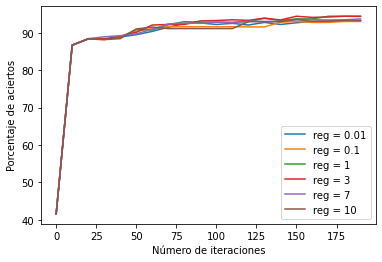

Scores:  [[41.55 86.75 88.35 88.25 88.9  89.5  90.4  91.5  92.5  92.65 92.25 92.55
  92.1  92.8  92.25 92.7  93.1  93.1  93.4  93.3 ]
 [41.55 86.75 88.35 88.2  88.9  90.45 91.15 91.65 91.65 91.65 91.65 91.65
  91.6  91.6  92.85 93.05 92.8  92.8  93.05 93.05]
 [41.55 86.65 88.4  88.3  88.85 90.9  90.75 92.2  93.   92.85 92.85 92.85
  93.   93.9  93.3  93.75 93.75 94.45 94.45 94.4 ]
 [41.55 86.65 88.45 88.4  89.1  90.15 92.1  92.25 92.25 93.2  93.3  93.5
  93.35 93.95 93.45 94.45 94.15 94.25 94.45 94.45]
 [41.55 86.7  88.45 88.95 89.25 89.75 90.95 92.4  92.6  92.55 92.9  92.7
  93.1  93.05 93.05 93.55 93.55 93.45 93.5  93.75]
 [41.55 86.75 88.4  88.2  88.45 91.05 91.55 91.15 91.15 91.15 91.15 91.15
  93.   93.   93.   93.6  93.05 93.15 93.3  93.3 ]] 

reg_max = 1 , iter_max = 170 , porcentaje acertado:  94.45 %


In [14]:
test_neurons(5)

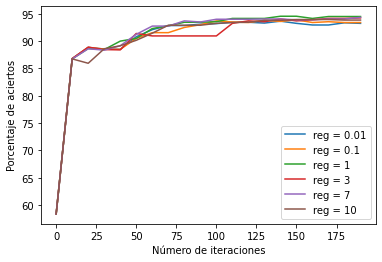

Scores:  [[58.4  86.8  88.85 88.55 88.5  90.8  92.1  92.85 92.85 93.1  93.2  93.45
  93.45 93.3  93.65 93.25 92.95 92.95 93.35 93.25]
 [58.4  86.8  88.85 88.55 88.5  90.5  91.55 91.55 92.5  93.   93.7  93.5
  93.4  93.8  93.6  93.9  93.4  93.55 93.4  93.4 ]
 [58.4  86.75 88.65 88.45 90.   90.5  92.3  92.8  93.45 93.45 93.55 94.15
  94.15 94.15 94.55 94.55 94.15 94.5  94.5  94.5 ]
 [58.4  86.8  88.9  88.45 88.4  91.4  90.95 90.95 90.95 90.95 90.95 93.25
  93.7  93.55 94.05 93.7  93.9  94.15 94.15 94.25]
 [58.4  86.75 88.6  88.35 89.15 91.25 92.75 92.75 93.7  93.5  94.   94.
  94.   94.05 94.05 93.9  93.9  94.05 94.05 94.35]
 [58.4  86.75 85.95 88.6  89.15 90.15 91.45 92.9  92.9  92.9  93.25 93.4
  93.45 93.8  93.8  93.95 93.95 93.95 93.85 93.85]] 

reg_max = 1 , iter_max = 140 , porcentaje acertado:  94.55 %


In [15]:
test_neurons(15)

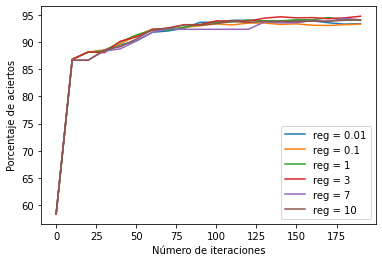

Scores:  [[58.4  86.85 88.15 88.2  89.45 90.2  91.8  92.05 92.55 93.65 93.65 94.
  94.   93.85 93.8  93.9  93.9  93.55 93.3  93.4 ]
 [58.4  86.85 88.15 88.55 89.65 91.15 92.4  92.4  92.7  93.   93.35 93.15
  93.5  93.5  93.25 93.35 93.1  93.05 93.2  93.3 ]
 [58.4  86.8  88.15 88.4  90.   91.3  92.2  92.2  92.75 93.25 93.7  93.7
  94.05 93.9  93.9  94.1  94.1  94.5  94.15 94.  ]
 [58.4  86.8  88.2  88.05 90.15 90.95 92.2  92.6  93.2  93.2  93.9  93.85
  93.85 94.4  94.65 94.45 94.5  94.3  94.45 94.75]
 [58.4  86.7  86.7  88.35 88.75 90.2  91.8  92.45 92.35 92.35 92.35 92.35
  92.35 93.7  93.55 93.55 93.95 93.8  94.35 94.1 ]
 [58.4  86.65 86.65 88.55 89.15 90.55 92.35 92.55 93.15 93.1  93.4  93.8
  93.6  93.8  93.8  93.8  93.85 93.85 94.   94.1 ]] 

reg_max = 3 , iter_max = 190 , porcentaje acertado:  94.75 %


In [16]:
test_neurons(25)

<ipython-input-7-cbeee0bb4e66>:5: RuntimeWarning: divide by zero encountered in log
  Term2 =  (1 - y) * np.log(1 - H)
<ipython-input-7-cbeee0bb4e66>:5: RuntimeWarning: invalid value encountered in multiply
  Term2 =  (1 - y) * np.log(1 - H)


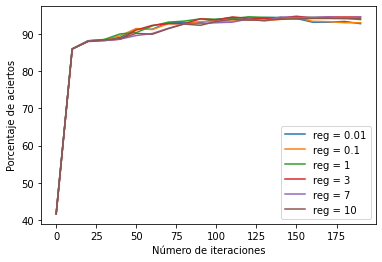

Scores:  [[41.6  86.05 88.25 88.5  89.15 91.45 91.35 93.15 93.15 93.15 94.   94.5
  94.3  94.5  94.5  94.25 93.25 93.25 93.45 92.85]
 [41.6  86.05 88.25 88.5  89.6  91.55 91.25 92.85 92.85 93.4  93.55 93.55
  93.95 93.6  94.   94.5  93.5  93.4  93.1  93.1 ]
 [41.6  86.05 88.2  88.6  90.1  90.45 92.25 93.25 93.55 94.15 94.05 94.2
  94.7  94.55 94.45 94.5  94.55 94.5  94.35 93.95]
 [41.6  86.05 88.05 88.3  88.65 91.15 92.4  92.85 92.85 94.15 93.85 94.65
  94.3  94.3  94.4  94.85 94.4  94.65 94.65 94.65]
 [41.6  86.   88.25 88.3  88.7  89.65 90.2  91.6  92.85 92.9  93.1  93.25
  94.1  93.65 94.65 94.5  94.55 94.65 94.4  94.65]
 [41.6  86.   88.1  88.45 88.8  90.25 90.   91.5  92.75 92.4  93.45 94.
  93.8  93.8  94.05 94.1  94.25 94.25 94.2  94.2 ]] 

reg_max = 3 , iter_max = 150 , porcentaje acertado:  94.85 %


In [17]:
test_neurons(50)

In [25]:
eInit = 0.12
num_entradas = X_train.shape[1]
num_ocultas = 25
num_etiquetas = 2
theta1 = np.random.random((num_ocultas,(num_entradas + 1)))*(2*eInit) - eInit
theta2 = np.random.random((num_etiquetas,(num_ocultas + 1)))*(2*eInit) - eInit
params_rn = np.concatenate((np.ravel(theta1), np.ravel(theta2)))
y_train_onehot = one_hot(y_train, 2)

Theta1, Theta2 = training(3, 200, params_rn, num_entradas, num_ocultas, num_etiquetas, X_train, y_train_onehot)
result = forward_propagation(Theta1, Theta2, X_test)[2]
success_rate(result, y_test)

93.55

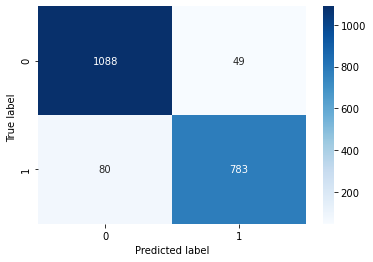

In [30]:
y_test_pred = []
for i in range(len(result)):
    y_test_pred.append(np.argmax(result[i]))
    
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Using Seaborn heatmap to create the plot
fx = sebrn.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')

# labels the title and x, y axis of plot
fx.set_xlabel('Predicted label')
fx.set_ylabel('True label ');

plt.savefig('figures/parte3/confusion_matrix.png')

In [31]:
# Accuracy, precision, recall and f1
target_names = ['neutral or dissatisfied', 'satisfied']
print(classification_report(y_test_pred, y_test, target_names=target_names))

                         precision    recall  f1-score   support

neutral or dissatisfied       0.96      0.93      0.94      1168
              satisfied       0.91      0.94      0.92       832

               accuracy                           0.94      2000
              macro avg       0.93      0.94      0.93      2000
           weighted avg       0.94      0.94      0.94      2000

